<h1>An Example of Attention Layer Plotting</h1>

This notebook is provided to implement a simple plotting of Attention Layer.

The data is from <a href=http://www.cbs.dtu.dk/services/DeepLoc/>deeploc</a> and the presentation is provided according to the <a href=https://github.com/JJAlmagro/subcellular_localization/blob/master/notebook%20tutorial/CNN-LSTM-Attention.ipynb>notebook</a> which made by the authors of deeploc. In the notebook The validation data is used for predicting instead of test dataset.Thus we followed the notebook and provided a similar one.

<h2>1. Preparation</h2>

In this notebook, few packages are necessary. 

Assuming that we are in <b>'root-of-autoBioSeqpy/notebook'</b>, then we need to add the search path and import the modules.

Please install <b>keras_self_attention, matplotlib, tensorFlow and keras</b> before using this notebook.

In [1]:
import os, sys
sys.path.append('../tool/libs')
sys.path.append('../')
oriPath = os.path.curdir
import paraParser
import moduleRead
import dataProcess
#import analysisPlot
import numpy as np
#from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
import tensorflow as tf
from utils import TextDecorate, evalStrList
from keras.models import Model
from keras.models import Sequential
import analysisPlot
# import umap
# import umap.plot
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

Using TensorFlow backend.


In [2]:
import keras_self_attention
from keras_self_attention import SeqSelfAttention
from keras.models import model_from_json

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

<h3>1.1 Model building</h3>

As the first step, we need a model from running.py, users could build a model by using the command line below in the root of autoBioSeqpy:

<b>python running.py --dataType protein --dataEncodingType dict  --dataTrainFilePaths ./examples/deeploc_data/data/Cell.membrane_train.fasta ./examples/deeploc_data/data/Cytoplasm_train.fasta ./examples/deeploc_data/data/Endoplasmic.reticulum_train.fasta ./examples/deeploc_data/data/Extracellular_train.fasta ./examples/deeploc_data/data/Golgi.apparatus_train.fasta ./examples/deeploc_data/data/Lysosome_Vacuole_train.fasta ./examples/deeploc_data/data/Mitochondrion_train.fasta ./examples/deeploc_data/data/Nucleus_train.fasta ./examples/deeploc_data/data/Peroxisome_train.fasta ./examples/deeploc_data/data/Plastid_train.fasta --dataTrainLabel 0 1 2 3 4 5 6 7 8 9 --dataTestFilePaths ./examples/deeploc_data/data/Cell.membrane_test.fasta ./examples/deeploc_data/data/Cytoplasm_test.fasta ./examples/deeploc_data/data/Endoplasmic.reticulum_test.fasta ./examples/deeploc_data/data/Extracellular_test.fasta ./examples/deeploc_data/data/Golgi.apparatus_test.fasta ./examples/deeploc_data/data/Lysosome_Vacuole_test.fasta ./examples/deeploc_data/data/Mitochondrion_test.fasta ./examples/deeploc_data/data/Nucleus_test.fasta ./examples/deeploc_data/data/Peroxisome_test.fasta ./examples/deeploc_data/data/Plastid_test.fasta --dataTestLabel 0 1 2 3 4 5 6 7 8 9 --modelLoadFile examples/deeploc_data/model/protein_CNN1D+MaxPooling_bi_att.py --verbose 1 --outSaveFolderPath tmpOut_800 --savePrediction 1 --saveFig 1 --batch_size 128 --epochs 50 --spcLen 2000 --shuffleDataTrain 1 --modelSaveName tmpMod.json --weightSaveName tmpWeight.bin --noGPU 0 --paraSaveName parameters.txt --labelToMat 1 --loss categorical_crossentropy</b>

The outputs will be saved at <b>../tmpOut</b>, including the parameters, the path of the data and constructure of the model.

Alternativly, a built model is already provided in <b>./tmpOutAttention</b>, thus users could skip this step by using the provided one. (The next steps will use the generated one, please change the path if users would like to use their own.)

If users would like to use their own model, please don't forget to save the model and the weight by using parameters "--modelSaveName" and "--weightSaveName".

<b>NOTE</b>: According to our test, building and training this model need more than 30GB memory, if users would like to train the model themself, please make sure the computing device having enough memory, or reduce the 'batch_size' to a smaller one.

<h3>1.2 Parameter pasering and data loading</h3>
The parameters are saved in <b>./tmpOutAttention/parameters.txt</b>, we can get the information easily by using the <b>paraParser</b> module.

In [4]:
paraFile = './tmpOutAttention/parameters.txt'
paraDict = paraParser.parseParametersFromFile(paraFile)
#print
for k in paraDict:
    print('%r: %r' %(k,paraDict[k]))

'dataType': ['protein']
'dataEncodingType': ['dict']
'spcLen': [2000]
'firstKernelSize': []
'dataTrainFilePaths': ['./examples/deeploc_data/data//Cell.membrane_train.fasta', './examples/deeploc_data/data//Cytoplasm_train.fasta', './examples/deeploc_data/data//Endoplasmic.reticulum_train.fasta', './examples/deeploc_data/data//Extracellular_train.fasta', './examples/deeploc_data/data//Golgi.apparatus_train.fasta', './examples/deeploc_data/data//Lysosome_Vacuole_train.fasta', './examples/deeploc_data/data//Mitochondrion_train.fasta', './examples/deeploc_data/data//Nucleus_train.fasta', './examples/deeploc_data/data//Peroxisome_train.fasta', './examples/deeploc_data/data//Plastid_train.fasta']
'dataTrainLabel': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
'dataTestFilePaths': ['./examples/deeploc_data/data//Cell.membrane_test.fasta', './examples/deeploc_data/data//Cytoplasm_test.fasta', './examples/deeploc_data/data//Endoplasmic.reticulum_test.fasta', './examples/deeploc_data/data//Extracellular_test.fa

Few preparing...
<b>Note</b>: according to  here we using the training data for presentation, 

In [5]:
outSaveFolderPath = './tmpOutAttention/' #change this path for using other output instead of the provided

As mentioned before, the validation datasets were used for presentation, here we followed the workflow by changing the test file into training file. Since keras using 'split' for generating validation dataset automaticly, we can use the whole train dataset for predicting.

In [6]:
paraDict['dataTestFilePaths'] = paraDict['dataTrainFilePaths']
paraDict['dataTestModelInd'] = paraDict['dataTrainModelInd']
paraDict['dataTestLabel'] = paraDict['dataTrainLabel']

In [7]:
# os.chdir('../')#to the root path of autoBioSeqpy


#parameters
dataTypeList = paraDict['dataType']
dataEncodingType = paraDict['dataEncodingType']
spcLen = paraDict['spcLen']
firstKernelSize = paraDict['firstKernelSize']

dataTestFilePaths = paraDict['dataTestFilePaths']
dataTestLabel = paraDict['dataTestLabel']

dataSplitScale = paraDict['dataSplitScale']
#outSaveFolderPath = paraDict['outSaveFolderPath']

showFig = paraDict['showFig']
saveFig = paraDict['saveFig']
savePrediction = paraDict['savePrediction']

loss = paraDict['loss']
optimizer = paraDict['optimizer']
if not optimizer.startswith('optimizers.'):
    optimizer = 'optimizers.' + optimizer
if not optimizer.endswith('()'):
    optimizer = optimizer + '()'
metrics = paraDict['metrics']

shuffleDataTrain = paraDict['shuffleDataTrain']
shuffleDataTest = paraDict['shuffleDataTest']
batch_size = paraDict['batch_size']
epochs = paraDict['epochs']

inputLength = paraDict['inputLength']
modelSaveName = paraDict['modelSaveName']
weightSaveName = paraDict['weightSaveName']
noGPU = paraDict['noGPU']
labelToMat = paraDict['labelToMat']


modelLoadFile = paraDict['modelLoadFile']
useKMerList = paraDict['useKMer']
if len(useKMerList ) == 0:
    useKMerList = [False] * len(modelLoadFile)
KMerNumList = paraDict['KMerNum']
if len(KMerNumList ) == 0:
    KMerNumList = [3] * len(modelLoadFile)
    
dataTestModelInd = paraDict['dataTestModelInd']
if len(modelLoadFile) == 1:
    dataTestModelInd = [0] * len(dataTestFilePaths)

modelPredictFile = outSaveFolderPath + os.path.sep + modelSaveName
weightLoadFile = outSaveFolderPath + os.path.sep + weightSaveName




Then we begin to generate the dataset by encoding the sequences.

The code below is from predicting.py, to see how the code works, please see the other notebook '<b>tutorial in jupyter notebook.ipynb</b>' instead.

In [10]:
workDir = os.getcwd()
print(workDir)

D:\workspace\autoBioSeqpy\notebook


In [11]:
os.chdir('..')
td = TextDecorate()
    
verbose = paraDict['verbose']

predictionSavePath = None
for i,k in enumerate(sys.argv):
    if k == '--predictionSavePath':
        predictionSavePath = sys.argv[i+1]
    elif k == '--verbose':
        verbose = sys.argv[i+1]

colorText = paraDict['colorText']
if colorText.lower() == 'auto':
    import platform
    if 'win' in platform.system().lower():
        td.disable()
elif not bool(eval(colorText)):
    td.disable()
    
if noGPU:
    if verbose:
        td.printC('As set by user, gpu will be disabled.','g')
    os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
else:
    #check the version of tensorflow before configuration
    tfVersion = tf.__version__
    if int(tfVersion.split('.')[0]) >= 2:
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True

        sess =tf.compat.v1.Session(config=config)
    else:
        config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
        sess = tf.Session(config=config)


if not len(dataTypeList) == len(modelLoadFile):
    if verbose:
        td.printC('Please provide enough data type(s) as the number of --modelLoadFile','r')
assert len(dataTypeList) == len(modelLoadFile)

featureGenerators = []
for i,subDataType in enumerate(dataTypeList):
    if subDataType.lower() == 'protein':
        if verbose:
            td.printC('Enconding protein data for model %d ...' %i,'b')
        featureGenerator = dataProcess.ProteinFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'dna':
        if verbose:
            td.printC('Enconding DNA data for model %d ...' %i,'b')
        featureGenerator = dataProcess.DNAFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'rna':
        if verbose:
            td.printC('Enconding RNA data for model %d ...' %i,'b')
        featureGenerator = dataProcess.RNAFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'other':
        if verbose:
            td.printC('Reading CSV-like data for model %d ...' %i,'b')
        featureGenerator = dataProcess.OtherFeatureGenerator()
    else:
        td.printC('Unknow dataType %r, please use \'protein\', \'dna\' ,\'rna\' or \'other\'' %subDataType, 'r')
    featureGenerators.append(featureGenerator)
    assert subDataType.lower() in ['protein','dna','rna','other']

if verbose:
    td.printC('Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...','b')
assert len(dataTestFilePaths) > 0

if verbose:
    td.printC('Begin to generate test dataset...','b')

testDataLoadDict = {}    
for modelIndex in range(len(modelLoadFile)):
    testDataLoadDict[modelIndex] = []
#    testDataLoaders = []
for i,dataPath in enumerate(dataTestFilePaths):
    modelIndex = dataTestModelInd[i]
    featureGenerator = featureGenerators[modelIndex]
    dataLoader = dataProcess.DataLoader(label = dataTestLabel[i], featureGenerator=featureGenerator)
    dataLoader.readFile(dataPath, spcLen = spcLen[modelIndex])
    testDataLoadDict[modelIndex].append(dataLoader)

testDataMats = []
testLabelArrs = []
testNameLists = []
for modelIndex in range(len(modelLoadFile)):
    testDataLoaders = testDataLoadDict[modelIndex]
    testDataSetCreator = dataProcess.DataSetCreator(testDataLoaders)
    testDataMat, testLabelArr, nameList = testDataSetCreator.getDataSet(toShuffle=False, withNameList=True)
    testDataMats.append(testDataMat)
    testLabelArrs.append(testLabelArr)
    testNameLists.append(nameList)
if verbose:
    td.printC('Test datasets generated.','g')
nameTemp = testNameLists[0]    
testDataMats, testLabelArrs, sortedIndexes = dataProcess.matAlignByName(testDataMats,nameTemp,testLabelArrs,testNameLists)
testNameLists = [nameTemp] * len(testNameLists)
    
tmpTempLabel = testLabelArrs[0]
for tmpLabel in testLabelArrs:
    assert np.sum(np.array(tmpTempLabel) - np.array(tmpLabel)) == 0   

if labelToMat:
    if verbose:
        td.printC('Since labelToMat is set, the labels would be changed to onehot-like matrix','g')
    testLabelArr,testLabelArrDict,testArrLabelDict = dataProcess.labelToMat(testLabelArrs[0])
#    print(testLabelArr)
else:
    testLabelArr = testLabelArrs[0]


Enconding protein data for model 0 ...
Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...
Begin to generate test dataset...
Test datasets generated.
Since labelToMat is set, the labels would be changed to onehot-like matrix


In [12]:
print('%d matrix generated:\n' %(len(testDataMats)))
for i in range(len(testDataMats)):
    print('Matrix and label %d:' %i)
    print(testDataMats[i])
    print(testLabelArr)
    print('\n')

1 matrix generated:

Matrix and label 0:
[[12 16  2 ... 20 20 20]
 [12 12 17 ... 20 20 20]
 [12  1 17 ... 20 20 20]
 ...
 [12  1 10 ... 20 20 20]
 [12  1  6 ... 20 20 20]
 [12  1  9 ... 20 20 20]]
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]




<h2>2. model preparing</h2>

Since here 3rd part module was used, a modified function below was provided for load the built model.

In [13]:
def readModelFromJsonFileDirectly(jsonFile,weightFile=None):
    json_file = open(jsonFile, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json, custom_objects=SeqSelfAttention.get_custom_objects())
    if not weightFile is None:
        # load weights into new model
        loaded_model.load_weights(weightFile)
    return loaded_model

In [14]:
os.chdir(workDir)
if verbose:
    td.printC('Checking module file for modeling','b')
if modelPredictFile is None:
    if verbose:
        td.printC('please provide a model file in a json file.','r')
if weightLoadFile is None:
    if verbose:
        td.printC('the weight file is necessary for predicting, otherwise the model will be with initialized weight','r')
assert not modelPredictFile is None
assert not weightLoadFile is None

if verbose:
    td.printC('Loading module and weight file','b')
model = readModelFromJsonFileDirectly(modelPredictFile,weightLoadFile)
if verbose:
    td.printC('Module loaded, generating the summary of the module','b')
    model.summary()

Checking module file for modeling
Loading module and weight file
Module loaded, generating the summary of the module
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 256)         6656      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1996, 250)         320250    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 998, 250)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 998, 128)          161280    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 998, 128)          8257      
___

Having the layers, first we findout the output of the attention layer and make a submodel. This model will be used later.

In [15]:
attModel = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('seq_self_attention_1').output])

<h2>3. Generating data for presentation</h2>

The layout in this section is referred to <a href=https://github.com/JJAlmagro/subcellular_localization/blob/master/notebook%20tutorial/CNN-LSTM-Attention.ipynb>the notebook of deeploc</a>,including the confusion matrix and the outputs from attention layer.

<h3>3.1 Generating the prediction</h3>
Here we provided the confusion matrix and few metrics of this prediction.

In [16]:
predicted_Probability = model.predict(testDataMats)

In [17]:
print(predicted_Probability.shape)

(11231, 10)


In [18]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [19]:
oriLabel = []
for tmpArr in testLabelArr:
    oriLabel.append(np.argmax(tmpArr))
predictedLabel = []
for tmpArr in predicted_Probability:
    predictedLabel.append(np.argmax(tmpArr))

In [20]:
cm=confusion_matrix(oriLabel,predictedLabel)
print(cm)
print('ACC: %.2f%%' %(accuracy_score(oriLabel,predictedLabel)*100))

[[1011   19   11    2    2    7    6    7    1    1]
 [   2 2040    2    6    1    1   21   88   12    7]
 [  17    6  636    6    5    8    6    1    2    2]
 [   3   12    5 1551    1    1    2    5    0    0]
 [   4   13    5    0  253    4    1    5    0    1]
 [   6   21    3    4    4  215    0    2    2    0]
 [   2   10    5    1    2    1 1176    2    3    6]
 [   4  103    2    3    1    0   10 3100    6    6]
 [   0    5    2    1    0    1    3    1  110    1]
 [   0    9    1    0    0    0    6    1    1  587]]
ACC: 95.09%


Plotting the confusion matrix in figure

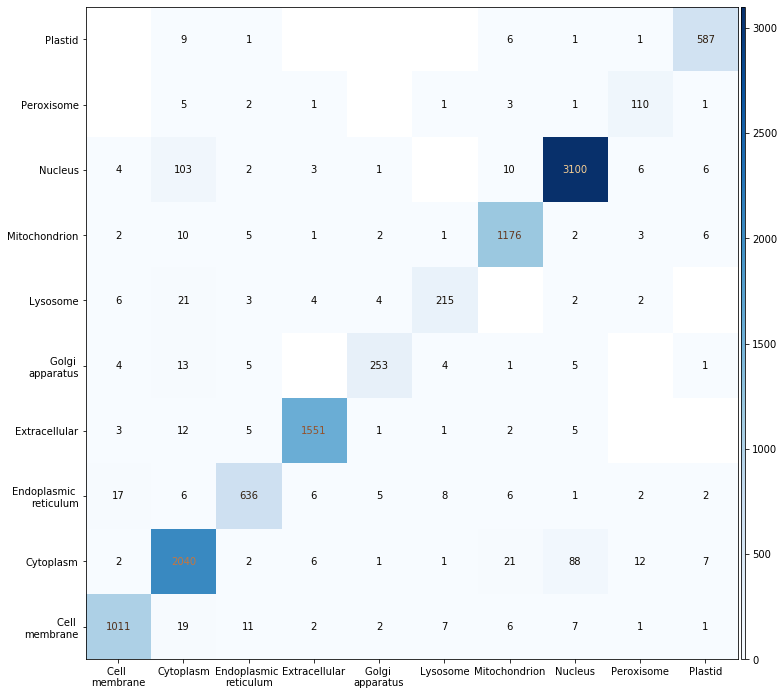

In [114]:
classes = ['Cell \nmembrane','Cytoplasm','Endoplasmic \nreticulum','Extracellular','Golgi \napparatus','Lysosome','Mitochondrion','Nucleus',
           'Peroxisome','Plastid']
analysisPlot.showMatWithVal(cm,precision='%d',xtickLabels=classes,ytickLabels=classes,toInvert=False,cmapName='Blues',figSize=(12,12))

<h3>3.2 Generating the output of attention layer</h3>

Using the submodel in section 3.1 to generate the output of attention layer. If using <b>keras_self_attention</b> for the attention layer, usually two matrix will be generated, the first is the correction with the output data, another is the output value (i.e. the value for next training). Here we will use both of the outputs for plotting.

In [29]:
att_Probability = attModel.predict(testDataMats)
print(len(att_Probability))

2


The first output:

In [30]:
att1 = np.array(att_Probability[0])
att1.shape

(11231, 10)

In [108]:
y_label = np.array(testLabelArrs[0]).reshape(11231,1)
y_label_for_plotting = y_label.dot(np.ones([1,100]))
print(y_label_for_plotting.shape)
print(y_label_for_plotting)

(11231, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]]


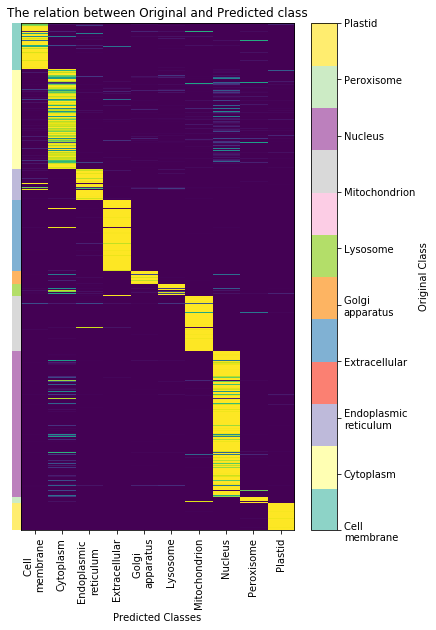

In [115]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15));

# labels_plot = ax1.imshow(y_label,cmap=plt.get_cmap('Set1'))
labels_plot = ax1.imshow(y_label_for_plotting,cmap=plt.get_cmap('Set3'))

ax1.set_aspect(0.3)
ax1.set_axis_off()
cb = plt.colorbar(labels_plot)
labels = np.arange(0,10,1)
loc = labels
cb.set_ticks(loc)
#cb.set_ticklabels(list(range(10)))
cb.set_ticklabels(classes)
cb.set_label('Original Class')
att_plot = ax2.imshow(att1, aspect='auto')
ax2.yaxis.set_visible(False)
ax2.set_xticks(labels)
ax2.set_xticklabels(classes,rotation=90)
plt.tight_layout(pad=24.5, w_pad=0.5, h_pad=1.0)
plt.xlabel('Predicted Classes')
plt.title('The relation between Original and Predicted class')
plt.show()

The second output

In [116]:
att2 = np.array(att_Probability[1])
att2.shape

(11231, 998, 128)

Since the dimension is larger than 1, a flatten and sum operation was launched before plotting.

In [139]:
att2_out = []
for i in range(att2.shape[0]):
    att2_out.append(att2[i,:].flatten())
att2_out = np.array(att2_out)
print(att2_out.shape)

(11231, 127744)


In [140]:
att2_out = att2.sum(axis=1)
print(att2_out.shape)

(11231, 128)


Normalizing, but could be skiped somehow. Usually the plotting itself could do the such operation.

In [141]:
att2_out = (att2_out - att2_out.min()) / (att2_out.max() - att2_out.min())

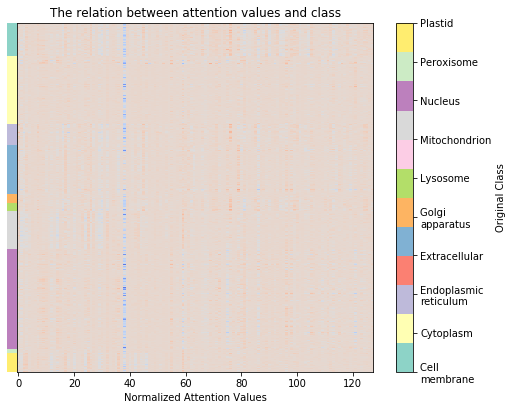

In [142]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15));

# labels_plot = ax1.imshow(y_label,cmap=plt.get_cmap('Set1'))
labels_plot = ax1.imshow(y_label_for_plotting,cmap=plt.get_cmap('Set3'))

ax1.set_aspect(0.3)
ax1.set_axis_off()
cb = plt.colorbar(labels_plot)
labels = np.arange(0,10,1)
loc = labels
cb.set_ticks(loc)
cb.set_ticklabels(classes)
cb.set_label('Original Class')
att_plot = ax2.imshow(att2_out, aspect='auto',cmap='coolwarm')
ax2.yaxis.set_visible(False)

plt.tight_layout(pad=35.5, w_pad=2, h_pad=1.0)
plt.xlabel('Normalized Attention Values')
plt.title('The relation between attention values and class')
plt.show()

That's all the informations for plotting the output of attention layer. If you still have more issues, please fell free to connect us at ljs@swmu.edu.cn, thanks.